<a href="https://colab.research.google.com/github/Mdtareef/SentimentAnalysis/blob/main/amazon_review_product_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d arhamrumi/amazon-product-reviews

 98% 112M/115M [00:00<00:00, 143MB/s] 
100% 115M/115M [00:00<00:00, 133MB/s]


In [ ]:
!unzip /content/amazon-product-reviews.zip

Archive:  /content/amazon-product-reviews.zip
  inflating: Reviews.csv             


In [ ]:
data=pd.read_csv("/content/Reviews.csv")

In [ ]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from wordcloud import WordCloud, STOPWORDS
import string
import re

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [ ]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [ ]:
data.shape

(568454, 10)

In [ ]:
#select text column score.
data1= data[['Text','Score']]
data1.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


(5    363122
 4     80655
 1     52268
 3     42640
 2     29769
 Name: Score, dtype: int64,
 <Axes: >)

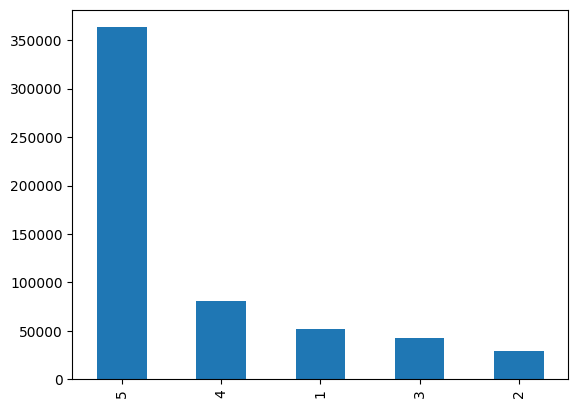

In [ ]:
#count of each rating/score
data1.Score.value_counts(), data1.Score.value_counts().plot(kind='bar')

In [ ]:
#check missing values:
data1.isna().sum()

Text     0
Score    0
dtype: int64

In [ ]:
data1[data1.duplicated()]

,Text,Score
29,I don't know if it's the cactus or the tequila...,5
574,"I'm addicted to salty and tangy flavors, so wh...",5
603,"I'm addicted to salty and tangy flavors, so wh...",5
1973,The pork chops from Omaha Steaks were very tas...,3
2309,Too much of the white pith on this orange peel...,2
...,...,...
568409,I was very pleased with the ingredient quality...,5
568410,My main reason for the five star review has to...,5
568411,I bought this to try on two registered Maine C...,5
568412,When we brought home two 3-month-old purebred ...,5


In [ ]:
data2=data1.drop_duplicates()
data2.head(), data2.shape

(                                                Text  Score
 0  I have bought several of the Vitality canned d...      5
 1  Product arrived labeled as Jumbo Salted Peanut...      1
 2  This is a confection that has been around a fe...      4
 3  If you are looking for the secret ingredient i...      2
 4  Great taffy at a great price.  There was a wid...      5,
 (393675, 2))

In [ ]:
data2.Score.value_counts()

5    250745
4     56074
1     36280
3     29772
2     20804
Name: Score, dtype: int64

In [ ]:
### converting data positive and nagative and neutral reviews

In [ ]:
def map_review(x):
  if x<3:
    return 'Negative'
  elif x==3:
    return 'Neutral'
  else:
    return 'Positive'

In [ ]:
data2['review'] = data2['Score'].apply(lambda x : map_review(x))

<ipython-input-19-f17bd15b6ae4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['review'] = data2['Score'].apply(lambda x : map_review(x))


In [ ]:
data2.head()

,Text,Score,review
0,I have bought several of the Vitality canned d...,5,Positive
1,Product arrived labeled as Jumbo Salted Peanut...,1,Negative
2,This is a confection that has been around a fe...,4,Positive
3,If you are looking for the secret ingredient i...,2,Negative
4,Great taffy at a great price. There was a wid...,5,Positive


In [ ]:
data2.review.value_counts()

Positive    306819
Negative     57084
Neutral      29772
Name: review, dtype: int64

In [ ]:
!pip install stop-words

  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=e6974b7d352ac58719f6effc1038ec21016fd822f2e1151b98afa055afa7f38d
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop-words


In [ ]:
#text processing and
import nltk
from stop_words import get_stop_words
stopwords = get_stop_words('english')

In [ ]:
# stopwords
total_stopwords = set(stopwords)

negative_stop_words = set(word for word in total_stopwords if "n't" in word or 'no' in word)
final_stopwords= total_stopwords-negative_stop_words

final_stopwords.add("one")
print(final_stopwords)

{'then', 'ours', "they'd", 'your', 'him', 'is', 'herself', "she's", "you're", 'its', 'did', 'during', 'against', 'than', 'this', 'yours', "i'd", 'before', 'if', 'about', "here's", 'to', 'there', 'too', 'how', 'each', 'here', 'as', 'we', 'could', 'very', 'yourselves', 'so', 'a', 'once', 'down', 'over', "that's", 'when', "why's", 'one', 'whom', 'such', 'they', 'which', 'should', 'other', 'between', 'had', 'hers', 'you', 'doing', "they're", "i've", 'theirs', 'why', "it's", "where's", "when's", 'yourself', 'been', 'it', 'these', 'until', 'below', 'again', 'of', "what's", 'by', 'was', 'and', 'own', "he'd", 'out', 'were', 'further', 'off', 'at', "i'm", 'on', 'our', "they'll", "i'll", 'her', "she'd", 'some', 'above', 'his', "he'll", 'who', 'after', 'ourselves', 'or', 'for', 'but', 'same', 'have', 'having', 'himself', 'those', 'only', 'would', 'both', 'does', 'through', 'she', 'under', 'are', 'am', 'into', 'most', 'in', 'me', 'them', 'being', "they've", 'because', 'up', 'more', 'ought', 'any',

In [ ]:
#stemming objecct
stemmer= PorterStemmer()

HTMLTAGS = re.compile('<.*?>')
table = str.maketrans(dict.fromkeys(string.punctuation))
remove_digits = str.maketrans('','',string.digits)
MULTIPLE_WHITESPACE = re.compile(r"\s+")

In [ ]:
#from tkinter import MULTIPLE
def Text_preprocessor(review):
  #remove html tags
  review = HTMLTAGS.sub(r'', review)
  #remove puncutualion
  review= review.translate(table)

  #remove digits
  review= review.translate(remove_digits)

#lower case all Latter
  review = review.lower()

#repace multiple white space with single space
  review = MULTIPLE_WHITESPACE.sub("", review).strip()

#remove stop words
  review = [word for word in review.split()
            if word not in final_stopwords]

#stemming
  review = ''.join([stemmer.stem(word) for word in review])
  return review

In [ ]:
text = 'I make 3 to 4 servings of each, use it in 3 days or less'

In [ ]:
Text_preprocessor(text)

'imaketoservingsofeachuseitindaysorless'

In [ ]:
def generate_wcloud(text):
  stopwords = set(STOPWORDS)

  wordcloud = WordCloud(stopwords=stopwords, background_color='white')
  wordcloud.generate(text)

  plt.figure(figsize=(15,7))
  plt.axis('off')
  plt.imshow(wordcloud, interpolation='bilinear')
  return plt.show()


In [ ]:
### positive review word cloud

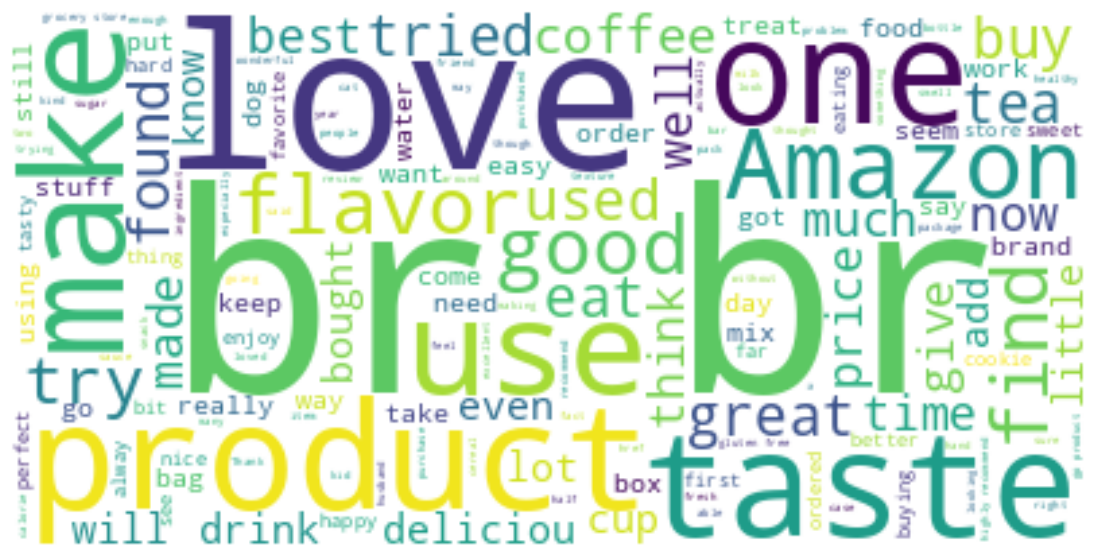

In [ ]:
 pos = data2.loc[data2.review == 'Positive'].Text
 text = " ". join(review for review in pos.astype(str))
 generate_wcloud(text)

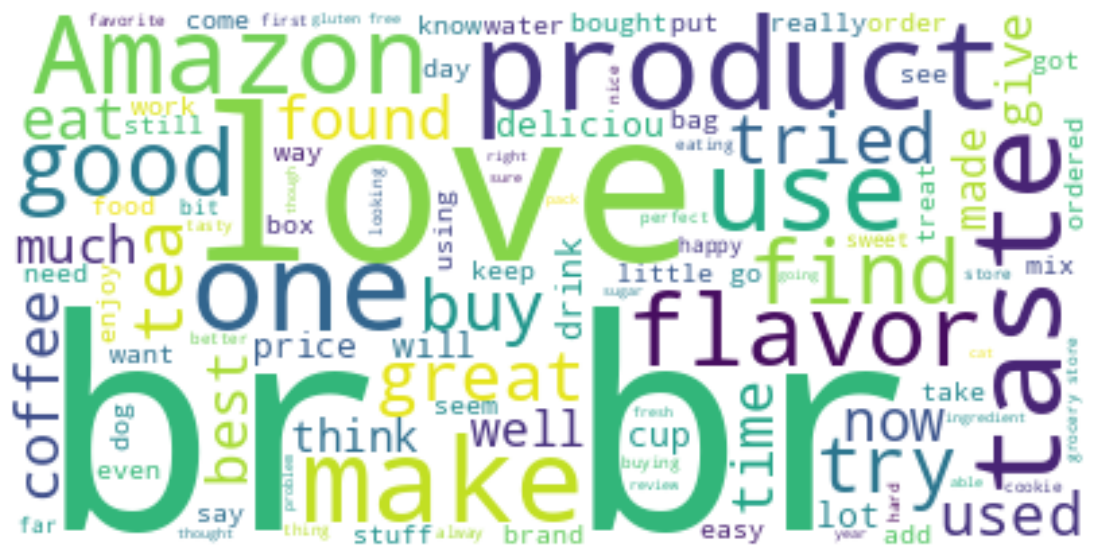

In [ ]:
#nagetive review wordcloud
Neg = data2.loc[data2.review == 'negative'].Text
text = " ". join(review for review in pos.astype(str))
generate_wcloud(text)

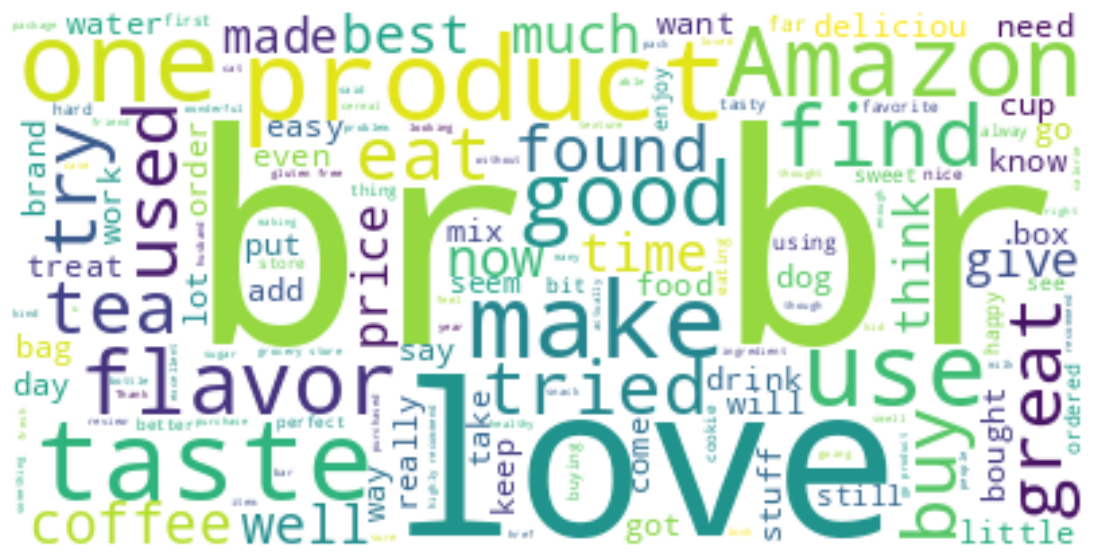

In [ ]:
#neutral wordcloud
Neut = data2.loc[data2.review == 'neutral'].Text
text = " ". join(review for review in pos.astype(str))
generate_wcloud(text)

In [ ]:
### spliting data set into training and testing dataset

In [ ]:
X= data2.Text
y=data2.Score

X_train, X_test , y_train, y_test=train_test_split(X,y, test_size=0.20, random_state=1, stratify=y)

In [ ]:
X_train.shape

(314940,)

In [ ]:
X_test.shape

(78735,)

In [ ]:
bow_vectorizer = CountVectorizer(max_features=10000)
bow_vectorizer.fit(X_train)
#tranform
bow_X_train = bow_vectorizer.transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)


In [ ]:
bow_X_train

<314940x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 16466953 stored elements in Compressed Sparse Row format>

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train)
#tranform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidfw_X_test = tfidf_vectorizer.transform(X_test)

In [ ]:

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

labels = label_encoder.classes_.tolist()  # Correct attribute name
print(labels)


[1, 2, 3, 4, 5]


In [ ]:
#model training and evaluation

In [ ]:
def train_and_eval(model, trainX, trainY, testX, testY):
  #training
  model.fit(trainX, trainY)

  #predictions
  y_preds_train= model.predict(trainX)
  y_preds_test = model.predict(testX)

  #evaluation

  print()
  print(model)
  print(f" Train accuracy score : { accuracy_score(y_train, y_preds_train)}")
  print(f" Train accuracy score : { accuracy_score(y_test, y_preds_train)}")
  print('\n', 40*'-')

In [ ]:
#hyperparameter

from sklearn.linear_model import LogisticRegression

C_values = [0.001, 0.01, 0.1, 1, 10]

for c in C_values:
    # Define and train the model
    model = LogisticRegression(C=c, max_iter=500, random_state=1)
    model.fit(bow_X_train, y_train)

    # Evaluate the model
    train_accuracy = model.score(bow_X_train, y_train)
    test_accuracy = model.score(bow_X_test, y_test)

    # Print the results
    print(f"For C = {c}:")
    print(f"  Train accuracy: {train_accuracy:.4f}")
    print(f"  Test accuracy: {test_accuracy:.4f}")



For C = 0.001:
  Train accuracy: 0.7015
  Test accuracy: 0.6972


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


For C = 0.01:
  Train accuracy: 0.7333
  Test accuracy: 0.7182


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


For C = 0.1:
  Train accuracy: 0.7515
  Test accuracy: 0.7215


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


For C = 1:
  Train accuracy: 0.7551
  Test accuracy: 0.7181
For C = 10:
  Train accuracy: 0.7563
  Test accuracy: 0.7167


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Naive-bays model - Hyperparameter & countvectorizer

In [ ]:
from sklearn.naive_bayes import MultinomialNB

alphas = [0, 0.2, 0.6, 0.8, 1]

models = [MultinomialNB(alpha=a) for a in alphas]

for model in models:
    model.fit(bow_X_train, y_train)
    train_accuracy = model.score(bow_X_train, y_train)
    test_accuracy = model.score(bow_X_test, y_test)

    print(f"For alpha = {model.alpha}:")
    print(f"  Train accuracy: {train_accuracy:.4f}")
    print(f"  Test accuracy: {test_accuracy:.4f}")



/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


For alpha = 0:
  Train accuracy: 0.6868
  Test accuracy: 0.6715
For alpha = 0.2:
  Train accuracy: 0.6866
  Test accuracy: 0.6718
For alpha = 0.6:
  Train accuracy: 0.6864
  Test accuracy: 0.6717
For alpha = 0.8:
  Train accuracy: 0.6864
  Test accuracy: 0.6720
For alpha = 1:
  Train accuracy: 0.6863
  Test accuracy: 0.6721
